In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import tqdm
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

from tempfile import TemporaryDirectory

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.manifold import TSNE

from PIL import Image

from google.colab import drive

cudnn.benchmark = True
plt.ion()

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
corneal_nerve_path = "/content/drive/MyDrive/Datasets/Corneal Nerve Images/Corneal Nerve Images"

corneal_nerve_image_list = []
corneal_nerve_image_labels = []

corneal_image_files = os.listdir(corneal_nerve_path)

corneal_nerve_normal = []
corneal_nerve_pathological = []

for corneal_image_file in corneal_image_files:
    corneal_image_path = os.path.join(corneal_nerve_path, corneal_image_file)
    corneal_nerve_image = Image.open(corneal_image_path).convert("L")
    corneal_nerve_image_list.append(np.array(corneal_nerve_image))
    if "non" in corneal_image_file.lower():
        corneal_nerve_pathological.append(corneal_image_file)
        corneal_nerve_image_labels.append("Pathological")
    else:
        corneal_nerve_normal.append(corneal_image_file)
        corneal_nerve_image_labels.append("Normal")
    # display(corneal_nerve_image)

corneal_nerve_image_list = np.array(corneal_nerve_image_list)

In [ ]:
corneal_nerve_image_list

array([[[ 5,  4,  4, ...,  2,  2,  2],
        [23, 23, 23, ..., 13,  8,  5],
        [30, 30, 30, ..., 15,  7,  1],
        ...,
        [23, 23, 23, ..., 11,  7,  8],
        [19, 19, 18, ...,  0,  0,  1],
        [ 5,  4,  3, ...,  1,  3,  8]],

       [[ 1,  1,  1, ...,  4,  2,  3],
        [23, 23, 23, ..., 14,  8,  7],
        [21, 21, 21, ..., 15,  7,  4],
        ...,
        [21, 21, 22, ...,  9,  4,  3],
        [15, 15, 16, ...,  4,  2,  3],
        [ 0,  0,  1, ...,  0,  0,  3]],

       [[ 2,  1,  0, ...,  1,  0,  5],
        [25, 25, 24, ..., 11,  2,  7],
        [19, 20, 21, ..., 14,  1,  3],
        ...,
        [21, 21, 21, ...,  5,  3,  4],
        [23, 23, 23, ...,  0,  0,  3],
        [ 1,  1,  1, ...,  2,  4,  8]],

       ...,

       [[ 1, 13, 18, ...,  3,  4,  2],
        [ 0,  9, 12, ...,  1,  1,  0],
        [ 3, 11, 13, ..., 11, 14, 13],
        ...,
        [ 1,  3,  6, ..., 10,  9,  4],
        [ 1,  3,  4, ...,  5,  6,  4],
        [ 1,  3,  3, ...,  6,  9

In [ ]:
corneal_nerve_image_labels

['Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Pathological',
 'Normal',
 'Pathological',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Pathological',
 'Normal',
 'Pathological',
 'Pathological',
 'Pathological',
 'Normal',
 'Pathological',
 'Pathological',
 'Normal',
 'Pathological',
 'Normal',
 'Pathological',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Pathological',
 'Normal',
 'Pathological',
 'Normal',
 'Pathological',
 'Normal',
 'Normal',
 'Pathological',
 'Normal',
 'Normal',
 'Normal',
 'N

In [ ]:
corneal_nerve_image_list.shape

(90, 576, 768)

In [ ]:
corneal_data = np.reshape(corneal_nerve_image_list, (corneal_nerve_image_list.shape[0], -1))
corneal_data = StandardScaler().fit_transform(corneal_data)

corneal_data.shape

(90, 442368)

In [ ]:
np.std(corneal_data, axis = 0)

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
corneal_log_reg_model = LogisticRegression(class_weight="balanced") # logreg corneal
corneal_linear_svc_model = LinearSVC(class_weight="balanced") # linear svc corneal
corneal_knn_model = KNeighborsClassifier(n_neighbors=3) # knn corneal
### corneal_gradient_boosting_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0) # gradient boosting corneal "Gradient Boosting": corneal_gradient_boosting_model,

def corneal_permute_labels(y):
    return shuffle(y)

corneal_N_permutations = 10

corneal_models = {
    "Logistic Regression": corneal_log_reg_model,
    "Linear SVC": corneal_linear_svc_model,
    "KNN": corneal_knn_model,
}

corneal_permuted_accuracies = {model_name: [] for model_name in corneal_models.keys()}
corneal_accuracies = {model_name: [] for model_name in corneal_models.keys()}

corneal_scaler = StandardScaler()

for i in tqdm.tqdm(range(corneal_N_permutations)):
    corneal_x_train, corneal_x_test, corneal_y_train, corneal_y_test = train_test_split(corneal_data, corneal_nerve_image_labels)

    corneal_scaler.fit(corneal_x_train)
    corneal_x_train = corneal_scaler.transform(corneal_x_train)
    corneal_x_test = corneal_scaler.transform(corneal_x_test)

    corneal_permuted_y_test = corneal_permute_labels(corneal_y_test)

    for corneal_model_name, corneal_model in corneal_models.items():
        corneal_model.fit(corneal_x_train, corneal_y_train)
        corneal_y_pred = corneal_model.predict(corneal_x_test)

        corneal_permuted_accuracy = accuracy_score(corneal_permuted_y_test, corneal_y_pred)
        corneal_permuted_accuracies[corneal_model_name].append(corneal_permuted_accuracy)

        corneal_accuracy = accuracy_score(corneal_y_test, corneal_y_pred)
        corneal_accuracies[corneal_model_name].append(corneal_accuracy)

for corneal_model_name, corneal_model in corneal_models.items():
    corneal_mean_accuracy = np.mean(corneal_accuracies[corneal_model_name])
    print(f"{corneal_model_name} Mean Accuracy: {corneal_mean_accuracy}")

 70%|███████   | 7/10 [05:26<02:22, 47.47s/it]

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

full_dataset = datasets.ImageFolder(corneal_nerve_path, data_transforms["train"])
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [0.8, 0.2])
data_dir = corneal_nerve_path
image_datasets = {"train": train_dataset, "val": test_dataset}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = full_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model


base_model = models.resnet50(pretrained=True)

for param in base_model.parameters():
    param.requires_grad = False

num_ftrs = base_model.fc.in_features
base_model.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(base_model.fc.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

corneal_transfer_model = train_model(base_model, criterion, optimizer, scheduler, num_epochs=10)

Epoch 0/9
----------


NameError: ignored

Text(0, 0.5, 'Classification Accuracy')

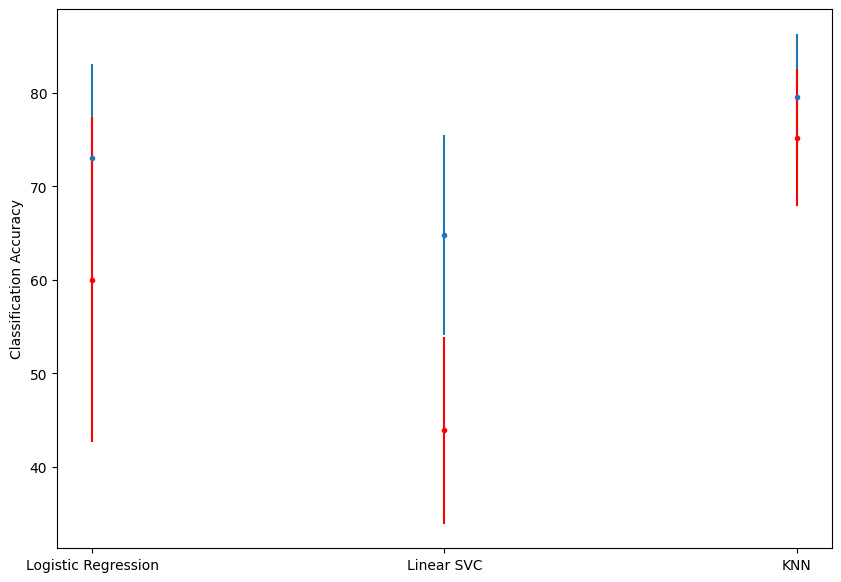

In [ ]:
fig, ax = plt.subplots(figsize = (10, 7))

y = [100*np.mean(corneal_accuracies[corneal_model]) for corneal_model in corneal_accuracies.keys()]
y_error = [100*np.std(corneal_accuracies[corneal_model]) for corneal_model in corneal_accuracies.keys()]

ax.errorbar(np.arange(len(corneal_models)), y, y_error, fmt = ".")
ax.set_xticks(np.arange(len(corneal_models)))
ax.set_xticklabels(corneal_models.keys())

y = [100*np.mean(corneal_permuted_accuracies[corneal_model]) for corneal_model in corneal_permuted_accuracies.keys()]
y_error = [100*np.std(corneal_permuted_accuracies[corneal_model]) for corneal_model in corneal_permuted_accuracies.keys()]

ax.errorbar(np.arange(len(corneal_models)), y, y_error, fmt = ".", color = "red")

ax.set_ylabel("Classification Accuracy")


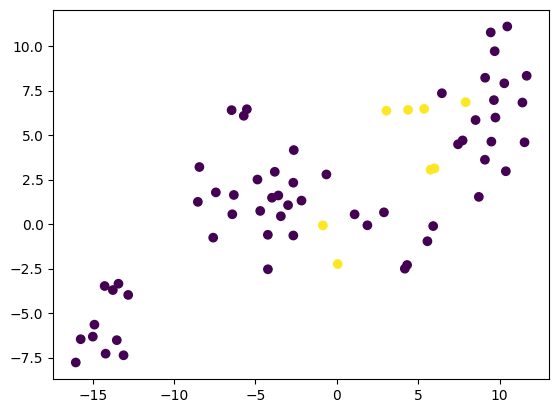

In [ ]:
corneal_x_train.shape

corneal_tsne = TSNE(perplexity=10.0)
corneal_x_tsne = corneal_tsne.fit_transform(corneal_x_train)
u, indices = np.unique(corneal_y_train, return_inverse=True)
plt.scatter(corneal_x_tsne[:, 0], corneal_x_tsne[:, 1], c=indices)

In [ ]:
corneal_y_train

['Normal',
 'Pathological',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Pathological',
 'Pathological',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Pathological',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Pathological',
 'Normal',
 'Pathological',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Pathological',
 'Pathological',
 'Normal',
 'Pathological',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Pathological',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Pathological',
 'Normal',
 'Normal',
 'Normal']

In [ ]:
nerve_tortuosity_path = "/content/drive/My Drive/Nerve Tortuosity"

nerve_tortuosity_image_list = []
nerve_tortuosity_image_labels = []

nerve_image_files = os.listdir(nerve_tortuosity_path)


nerve_tortuosity_low = ["image01.tif", "image02.tif", "image03.tif", "image04.tif", "image05.tif", "image07.tif", "image08.tif","image09.tif", "image10.tif", "image11.tif"]
nerve_tortuosity_mid = ["image12.tif", "image15.tif", "image16.tif", "image17.tif", "image19.tif", "image20.tif", "image21.tif", "image22.tif", "image23.tif", "image25.tif"]
nerve_tortuosity_high = ["image06.tif", "image13.tif", "image14.tif", "image18.tif", "image24.tif", "image26.tif", "image27.tif", "image28.tif", "image29.tif", "image30.tif"]



for nerve_image_file in nerve_image_files:
    nerve_image_path = os.path.join(nerve_tortuosity_path, nerve_image_file)
    if nerve_image_path.lower().endswith((".tif", ".jpg", ".jpeg", ".png", ".gif", ".bmp")):
        nerve_tortuosity_image = Image.open(nerve_image_path)
        nerve_tortuosity_image_list.append(np.array(nerve_tortuosity_image))
        if nerve_image_file in nerve_tortuosity_low:
            nerve_tortuosity_image_labels.append("low")
        elif nerve_image_file in nerve_tortuosity_mid:
            nerve_tortuosity_image_labels.append("mid")
        elif nerve_image_file in nerve_tortuosity_high:
            nerve_tortuosity_image_labels.append("high")
        #display(nerve_tortuosity_image)

nerve_tortuosity_image_list = np.array(nerve_tortuosity_image_list)


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


In [ ]:
nerve_tortuosity_image_labels


['high',
 'low',
 'low',
 'low',
 'high',
 'low',
 'low',
 'low',
 'low',
 'low',
 'high',
 'high',
 'low',
 'mid',
 'low',
 'mid',
 'high',
 'mid',
 'mid',
 'high',
 'mid',
 'mid',
 'mid',
 'mid',
 'high',
 'mid',
 'high',
 'high',
 'high',
 'mid']

In [ ]:
nerve_tortuosity_image_list.shape

(30, 384, 384)

In [ ]:
nerve_data = np.reshape(nerve_tortuosity_image_list, (nerve_tortuosity_image_list.shape[0], -1))
nerve_data = StandardScaler().fit_transform(nerve_data) # standardscaler offers better accuracy

nerve_data.shape

(30, 147456)

In [ ]:
np.std(nerve_data, axis = 0)

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
nerve_log_reg_model = LogisticRegression() # logreg
nerve_linear_svc_model = LinearSVC() # linear svc
nerve_knn_model = KNeighborsClassifier(n_neighbors=3) # knn
nerve_gradient_boosting_model = GradientBoostingClassifier(n_estimators=200, learning_rate=1.0) # gradient boosting

def nerve_permute_labels(y):
    return shuffle(y)

nerve_N_permutations = 10

nerve_models = {
    "Logistic Regression": nerve_log_reg_model,
    "Linear SVC": nerve_linear_svc_model,
    "KNN": nerve_knn_model,
    "Gradient Boosting": nerve_gradient_boosting_model,
}

nerve_permuted_accuracies = {model_name: [] for model_name in nerve_models.keys()}
nerve_accuracies = {model_name: [] for model_name in nerve_models.keys()}

nerve_scaler = StandardScaler()

for i in tqdm.tqdm(range(nerve_N_permutations)):
    nerve_x_train, nerve_x_test, nerve_y_train, nerve_y_test = train_test_split(nerve_data, nerve_tortuosity_image_labels)

    nerve_scaler.fit(nerve_x_train)
    nerve_x_train = nerve_scaler.transform(nerve_x_train)
    nerve_x_test = nerve_scaler.transform(nerve_x_test)

    nerve_permuted_y_test = nerve_permute_labels(nerve_y_test)


    for nerve_model_name, nerve_model in nerve_models.items():
        nerve_model.fit(nerve_x_train, nerve_y_train)
        nerve_y_pred = nerve_model.predict(nerve_x_test)

        nerve_permuted_accuracy = accuracy_score(nerve_permuted_y_test, nerve_y_pred)
        nerve_permuted_accuracies[nerve_model_name].append(nerve_permuted_accuracy)

        nerve_accuracy = accuracy_score(nerve_y_test, nerve_y_pred)
        nerve_accuracies[nerve_model_name].append(nerve_accuracy)


for nerve_model_name, nerve_model_model in nerve_models.items():
    nerve_mean_accuracy = np.mean(nerve_accuracies[nerve_model_name])
    print(f"{nerve_model_name} Mean Accuracy: {nerve_mean_accuracy}")

100%|██████████| 10/10 [04:39<00:00, 27.96s/it]

Logistic Regression Mean Accuracy: 0.4125
Linear SVC Mean Accuracy: 0.475
KNN Mean Accuracy: 0.375
Gradient Boosting Mean Accuracy: 0.4875


Text(0, 0.5, 'Classification Accuracy')

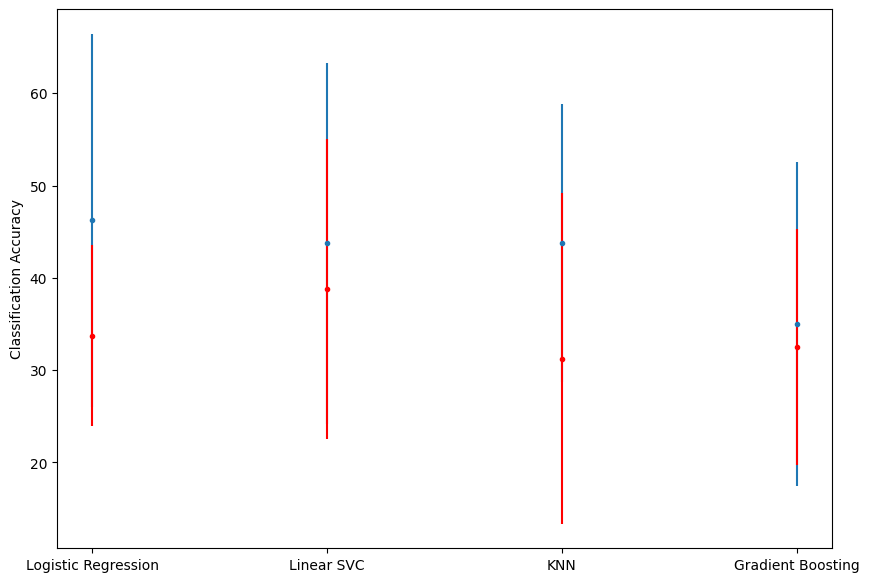

In [ ]:
fig, ax = plt.subplots(figsize = (10, 7))

y = [100*np.mean(nerve_accuracies[nerve_model]) for nerve_model in nerve_accuracies.keys()]
y_error = [100*np.std(nerve_accuracies[nerve_model]) for nerve_model in nerve_accuracies.keys()]

ax.errorbar(np.arange(len(nerve_models)), y, y_error, fmt = ".")
ax.set_xticks(np.arange(len(nerve_models)))
ax.set_xticklabels(nerve_models.keys())

y = [100*np.mean(nerve_permuted_accuracies[nerve_model]) for nerve_model in nerve_permuted_accuracies.keys()]
y_error = [100*np.std(nerve_permuted_accuracies[nerve_model]) for nerve_model in nerve_permuted_accuracies.keys()]

ax.errorbar(np.arange(len(nerve_models)), y, y_error, fmt = ".", color = "red")

ax.set_ylabel("Classification Accuracy")


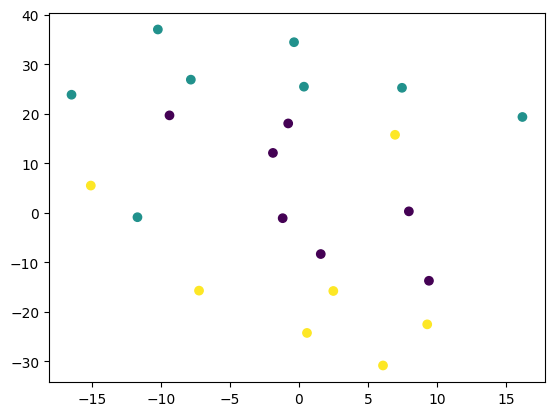

In [ ]:
nerve_x_train.shape

nerve_tsne = TSNE(perplexity=10.0)
nerve_x_tsne = nerve_tsne.fit_transform(nerve_x_train)
u, indices = np.unique(nerve_y_train, return_inverse=True)
plt.scatter(nerve_x_tsne[:, 0], nerve_x_tsne[:, 1], c=indices)

In [ ]:
nerve_y_train

['high',
 'mid',
 'mid',
 'mid',
 'high',
 'low',
 'mid',
 'low',
 'low',
 'mid',
 'high',
 'low',
 'low',
 'high',
 'high',
 'mid',
 'mid',
 'low',
 'low',
 'high',
 'mid',
 'mid']

In [ ]:
nerve_y_test

['low', 'low', 'low', 'high', 'high', 'high', 'mid', 'high']

In [ ]:
nerve_y_pred

array(['low', 'low', 'low', 'mid', 'mid', 'low', 'high', 'mid'],
      dtype='<U4')

In [ ]:
diabetic_retinopathy_path = "/content/drive/MyDrive/Datasets/Diabetic Retinopathy/colored_images"

diabetic_retinopathy_image_list = []
diabetic_retinopathy_image_labels = []


diabetic_retinopathy_none = "/content/drive/MyDrive/Datasets/Diabetic Retinopathy/colored_images/No_DR"
diabetic_retinopathy_none = []

diabetic_retinopathy_mild = "/content/drive/MyDrive/Datasets/Diabetic Retinopathy/colored_images/Mild"
diabetic_retinopathy_mild = []

diabetic_retinopathy_moderate = "/content/drive/MyDrive/Datasets/Diabetic Retinopathy/colored_images/Moderate"
diabetic_retinopathy_moderate = []

diabetic_retinopathy_proliferate = "/content/drive/MyDrive/Datasets/Diabetic Retinopathy/colored_images/Proliferate_DR"
diabetic_retinopathy_proliferate = []

diabetic_retinopathy_severe = "/content/drive/MyDrive/Datasets/Diabetic Retinopathy/colored_images/Severe"
diabetic_retinopathy_severe = []



for diabetic_retinopathy_folder in ["No_DR", "Mild", "Moderate", "Proliferate_DR", "Severe"]:
    diabetic_retinopathy_folder_path = os.path.join(diabetic_retinopathy_path, diabetic_retinopathy_folder)

    for diabetic_retinopathy_image_file in os.listdir(diabetic_retinopathy_folder_path):
        diabetic_retinopathy_image_path = os.path.join(diabetic_retinopathy_folder_path, diabetic_retinopathy_image_file)
        diabetic_retinopathy_image = Image.open(diabetic_retinopathy_image_path)

        diabetic_retinopathy_image_list.append(np.array(diabetic_retinopathy_image))

        if diabetic_retinopathy_folder == "No_DR":
            diabetic_retinopathy_image_labels.append("None")
            diabetic_retinopathy_none.append("None")
        elif diabetic_retinopathy_folder == "Mild":
            diabetic_retinopathy_image_labels.append("Mild")
            diabetic_retinopathy_mild.append("Mild")
        elif diabetic_retinopathy_folder == "Moderate":
            diabetic_retinopathy_image_labels.append("Moderate")
            diabetic_retinopathy_moderate.append("Moderate")
        elif diabetic_retinopathy_folder == "Proliferate_DR":
            diabetic_retinopathy_image_labels.append("Proliferate")
            diabetic_retinopathy_proliferate.append("Proliferate")
        elif diabetic_retinopathy_folder == "Severe":
            diabetic_retinopathy_image_labels.append("Severe")
            diabetic_retinopathy_severe.append("Severe")

diabetic_retinopathy_image_list = np.array(diabetic_retinopathy_image_list)

In [ ]:
diabetic_retinopathy_image_list.shape

(3671, 224, 224, 3)

In [ ]:
diabetic_retinopathy_data = np.reshape(diabetic_retinopathy_image_list, (diabetic_retinopathy_image_list.shape[0], -1))
diabetic_retinopathy_data = StandardScaler().fit_transform(diabetic_retinopathy_data)

diabetic_retinopathy_data.shape

(3671, 150528)

In [ ]:
len(diabetic_retinopathy_image_labels)

3671

In [ ]:
np.std(diabetic_retinopathy_data, axis = 0)

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
diabetic_retinopathy_image_labels = np.array(diabetic_retinopathy_image_labels)

In [ ]:
diabetic_retinopathy_log_reg_model = LogisticRegression() # logreg
diabetic_retinopathy_linear_svc_model = LinearSVC() # linear svc
diabetic_retinopathy_knn_model = KNeighborsClassifier(n_neighbors=3) # knn
## diabetic_retinopathy_gradient_boosting_model = GradientBoostingClassifier(n_estimators=200, learning_rate=1.0) # gradient boosting

def diabetic_retinopathy_permute_labels(y):
    return shuffle(y)

diabetic_retinopathy_N_permutations = 10

diabetic_retinopathy_models = {
    "Logistic Regression": diabetic_retinopathy_log_reg_model,
    "Linear SVC": diabetic_retinopathy_linear_svc_model,
    "KNN": diabetic_retinopathy_knn_model,
    ## "Gradient Boosting": diabetic_retinopathy_gradient_boosting_model,
}

diabetic_retinopathy_permuted_accuracies = {model_name: [] for model_name in diabetic_retinopathy_models.keys()}
diabetic_retinopathy_accuracies = {model_name: [] for model_name in diabetic_retinopathy_models.keys()}

diabetic_retinopathy_scaler = StandardScaler()

for i in tqdm.tqdm(range(diabetic_retinopathy_N_permutations)):
    subset_index = np.random.randint(0, len(diabetic_retinopathy_image_labels), size=1000)
    diabetic_retinopathy_data_subset = diabetic_retinopathy_data[subset_index, :]
    diabetic_retinopathy_labels_subset = diabetic_retinopathy_image_labels[subset_index]

    diabetic_retinopathy_x_train, diabetic_retinopathy_x_test, diabetic_retinopathy_y_train, diabetic_retinopathy_y_test = train_test_split(diabetic_retinopathy_data_subset, diabetic_retinopathy_labels_subset)

    diabetic_retinopathy_permuted_y_test = diabetic_retinopathy_permute_labels(diabetic_retinopathy_y_test)


    for diabetic_retinopathy_model_name, diabetic_retinopathy_model in diabetic_retinopathy_models.items():
        diabetic_retinopathy_model.fit(diabetic_retinopathy_x_train, diabetic_retinopathy_y_train)
        diabetic_retinopathy_y_pred = diabetic_retinopathy_model.predict(diabetic_retinopathy_x_test)

        diabetic_retinopathy_permuted_accuracy = accuracy_score(diabetic_retinopathy_permuted_y_test, diabetic_retinopathy_y_pred)
        diabetic_retinopathy_permuted_accuracies[diabetic_retinopathy_model_name].append(diabetic_retinopathy_permuted_accuracy)

        diabetic_retinopathy_accuracy = accuracy_score(diabetic_retinopathy_y_test, diabetic_retinopathy_y_pred)
        diabetic_retinopathy_accuracies[diabetic_retinopathy_model_name].append(diabetic_retinopathy_accuracy)


for diabetic_retinopathy_model_name, diabetic_retinopathy_model_model in diabetic_retinopathy_models.items():
    diabetic_retinopathy_mean_accuracy = np.mean(diabetic_retinopathy_accuracies[diabetic_retinopathy_model_name])
    print(f"{diabetic_retinopathy_model_name} Mean Accuracy: {diabetic_retinopathy_mean_accuracy}")

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    accuracy = {"train": [], "val": []}

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phas
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    accuracy[phase].append(torch.sum(preds == labels.data) / len(preds))
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, accuracy

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

best_model_params_path = 'best_model_params.pt'

data = torchvision.datasets.ImageFolder(root=diabetic_retinopathy_path, transform=data_transforms["train"])
train_dataset, test_dataset = torch.utils.data.random_split(data, [0.8, 0.2])

# train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=4)
# test_data_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=True, num_workers=4)

image_datasets = {"train": train_dataset, "val": test_dataset}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True).to(device)

for param in model.parameters():
    param.requires_grad = False

num_classes = 5
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


diabetic_retinopathy_transfer_model, diabetic_retinopathy_transfer_model_accuracy = train_model(model, criterion, optimizer, scheduler, num_epochs=1)

torch.save(diabetic_retinopathy_transfer_model.state_dict(), best_model_params_path)


# for epoch in range(10):
    # for batch in train_data_loader:
        # outputs = model(batch.images)

        # loss = criterion(outputs, batch.labels)

        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()

# accuracy = eval(model, test_data_loader)

# print("Accuracy:{}".format(accuracy))



Epoch 0/0
----------
train Loss: 1.0076 Acc: 0.6374
val Loss: 0.8074 Acc: 0.7548

Training complete in 10m 36s
Best val Acc: 0.754768


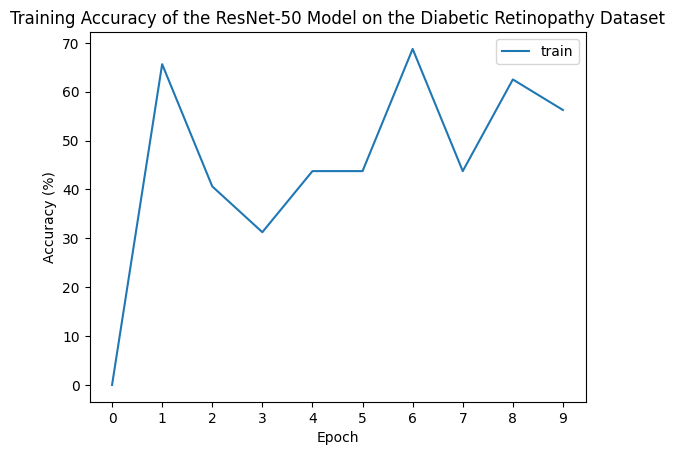

In [ ]:
train_accuracy_percentage = np.array(diabetic_retinopathy_transfer_model_accuracy['train'][0:10]) * 100

plt.plot(train_accuracy_percentage, label="train")
plt.title('Training Accuracy of the ResNet-50 Model on the Diabetic Retinopathy Dataset')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.xticks(np.arange(10))
plt.legend()
plt.show()


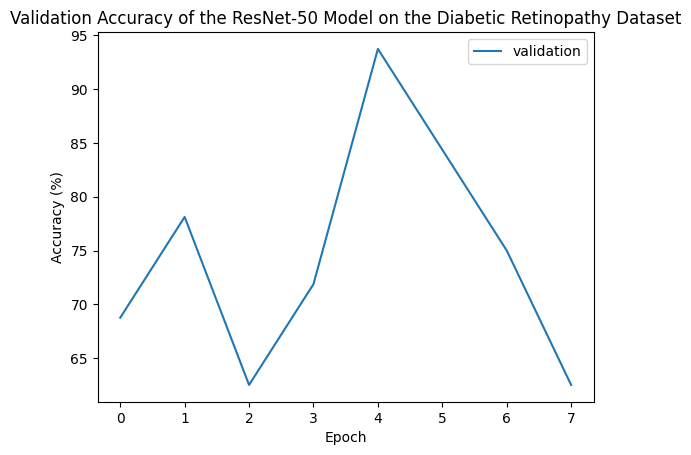

In [ ]:

val_accuracy_percentage = np.array(diabetic_retinopathy_transfer_model_accuracy['val'][0:8]) * 100

plt.plot(val_accuracy_percentage, label="validation")
plt.title('Validation Accuracy of the ResNet-50 Model on the Diabetic Retinopathy Dataset')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()


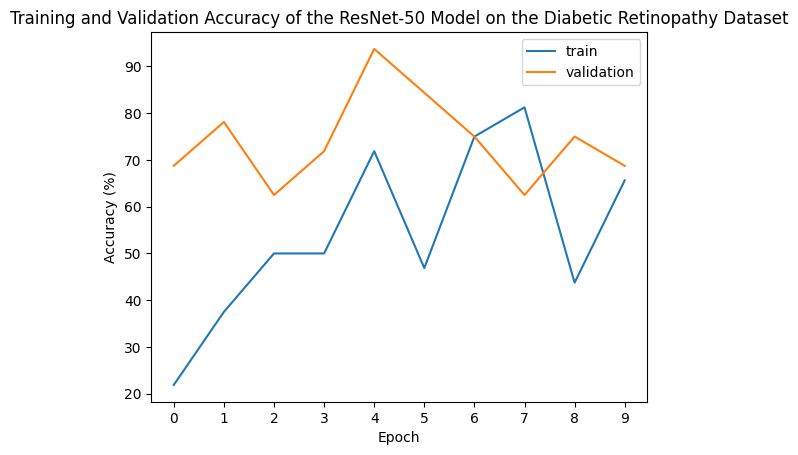

In [ ]:
# prompt: plot both the training and validation accuracy of the model on one plot

train_accuracy_percentage = np.array(diabetic_retinopathy_transfer_model_accuracy['train'][0:10]) * 100

val_accuracy_percentage = np.array(diabetic_retinopathy_transfer_model_accuracy['val'][0:10]) * 100

plt.plot(train_accuracy_percentage, label="train")
plt.plot(val_accuracy_percentage, label="validation")
plt.title('Training and Validation Accuracy of the ResNet-50 Model on the Diabetic Retinopathy Dataset')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.xticks(np.arange(10))
plt.legend()
plt.show()


In [ ]:
import torch
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.feature_maps = None
        self.register_hooks()

    def register_hooks(self):
        self.target_layer.register_forward_hook(self.save_feature_maps)
        self.target_layer.register_backward_hook(self.save_gradients)

    def save_feature_maps(self, module, input, output):
        self.feature_maps = output

    def save_gradients(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def generate_heatmap(self, output, class_idx):
        for param in self.target_layer.parameters():
            param.requires_grad = True

        self.model.zero_grad()
        output[:, class_idx].backward()
        gradients = self.gradients.data[0]
        pooled_gradients = torch.mean(gradients, dim=[1, 2])
        feature_maps = self.feature_maps.data[0]

        for i in range(feature_maps.size(0)):
            feature_maps[i] *= pooled_gradients[i]

        heatmap = torch.mean(feature_maps, dim=0)
        heatmap = np.maximum(heatmap.detach().cpu().numpy(), 0)
        heatmap /= np.max(heatmap)

        return heatmap

    def apply_heatmap(self, heatmap, original_image, alpha=0.5):
        heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_RAINBOW)
        superimposed_img = heatmap * alpha + original_image * (1 - alpha)
        return superimposed_img

# Example usage
# Load your finetuned ResNet model
model = diabetic_retinopathy_transfer_model  # Load your model here
model.eval()

# Identify the target layer (e.g., the last convolutional layer)
target_layer = model.layer4[-1]

# Initialize GradCAM
gradcam = GradCAM(model, target_layer)

# Prepare your image (ensure it's normalized and in the correct format)
img_path = "/content/drive/MyDrive/Datasets/Diabetic Retinopathy/colored_images/Proliferate_DR/cd93a472e5cd.png"
img = Image.open(img_path)
transform = data_transforms['val']
input_image = transform(img).to(device)

# Perform a forward pass to get the output
output = model(input_image.unsqueeze(0))

# Specify the class index for which you want to visualize the heatmap
class_idx = torch.argmax(output).item()

# Generate the heatmap
heatmap = gradcam.generate_heatmap(output, class_idx)

# Convert your input image to a format suitable for overlaying with the heatmap
original_image = np.array(input_image.squeeze().permute(1, 2, 0).cpu())
original_image = (original_image * 255).astype(np.uint8)

# Apply the heatmap to the original image
superimposed_img = gradcam.apply_heatmap(heatmap, np.array(img))

# Display or save superimposed_img as needed


(tensor([[[[ 0.0004,  0.0004,  0.0004,  ...,  0.0004,  0.0004,  0.0004],
          [ 0.0004,  0.0004,  0.0004,  ...,  0.0004,  0.0004,  0.0004],
          [ 0.0004,  0.0004,  0.0004,  ...,  0.0004,  0.0004,  0.0004],
          ...,
          [ 0.0004,  0.0004,  0.0004,  ...,  0.0004,  0.0004,  0.0004],
          [ 0.0004,  0.0004,  0.0004,  ...,  0.0004,  0.0004,  0.0004],
          [ 0.0004,  0.0004,  0.0004,  ...,  0.0004,  0.0004,  0.0004]],

         [[-0.0001, -0.0001, -0.0001,  ..., -0.0001, -0.0001, -0.0001],
          [-0.0001, -0.0001, -0.0001,  ..., -0.0001, -0.0001, -0.0001],
          [-0.0001, -0.0001, -0.0001,  ..., -0.0001, -0.0001, -0.0001],
          ...,
          [-0.0001, -0.0001, -0.0001,  ..., -0.0001, -0.0001, -0.0001],
          [-0.0001, -0.0001, -0.0001,  ..., -0.0001, -0.0001, -0.0001],
          [-0.0001, -0.0001, -0.0001,  ..., -0.0001, -0.0001, -0.0001]],

         [[-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002],
          [-0.0002, -0.0002, 

Text(0.5, 1.0, 'Original Image + Heatmap')

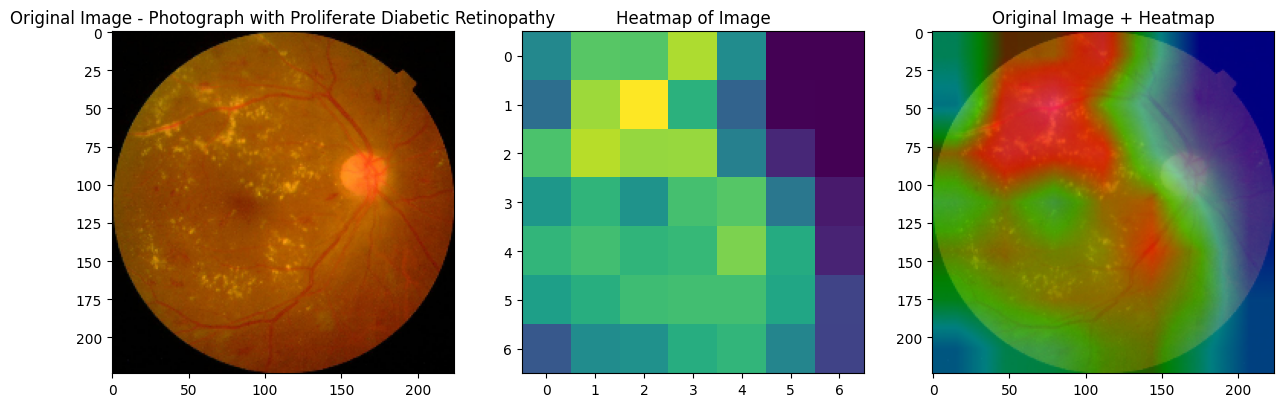

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img)
ax[0].set_title("Original Image - Photograph with Proliferate Diabetic Retinopathy")

ax[1].imshow(heatmap)
ax[1].set_title("Heatmap of Image")

ax[2].imshow(superimposed_img.astype(np.uint8))
ax[2].set_title("Original Image + Heatmap")


In [ ]:
plt.imshow(hea)

float64


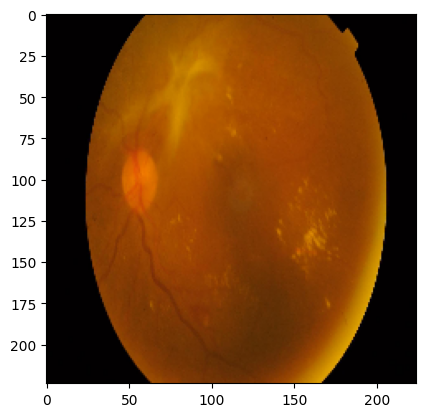

In [ ]:
plt.imshow(img)

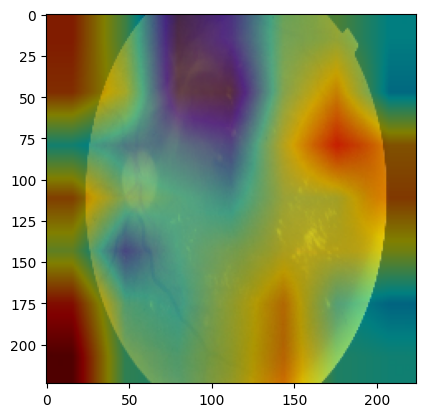

In [ ]:
plt.imshow(superimposed_img.astype(np.uint8))

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
for inputs, labels in dataloaders["val"]:
    print(inputs.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([30, 3, 224, 224])


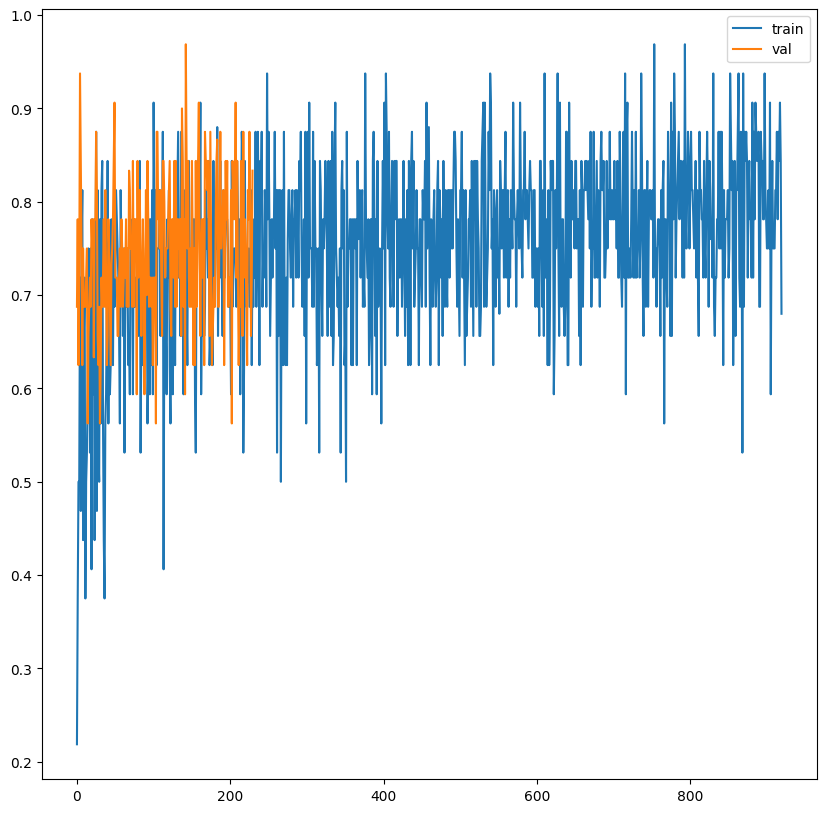

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))

ax.plot(np.arange(len(diabetic_retinopathy_transfer_model_accuracy["train"])), diabetic_retinopathy_transfer_model_accuracy["train"], label = "train")
ax.plot(np.arange(len(diabetic_retinopathy_transfer_model_accuracy["val"])), diabetic_retinopathy_transfer_model_accuracy["val"], label = "val")

ax.legend()
